In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
import torchvision.utils as vutils
import os

# Set random seed for reproducibility
manualSeed = 6789
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manualSeed)

# Generator shared layers
class GeneratorSharedLayers(nn.Module):
    def __init__(self, ngf, nc):
        super(GeneratorSharedLayers, self).__init__()
        self.main = nn.Sequential(
            # First upsampling
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Second upsampling
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Third upsampling
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Output layer
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Generator with unique input layer and shared layers
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, shared_layers):
        super(Generator, self).__init__()
        self.ngf = ngf  # Store ngf as an instance variable
        self.input_layer = nn.Sequential(
            nn.Linear(nz, ngf * 8 * 4 * 4),
            nn.BatchNorm1d(ngf * 8 * 4 * 4),
            nn.ReLU(True)
        )
        self.shared_layers = shared_layers

    def forward(self, input):
        x = self.input_layer(input)
        x = x.view(-1, self.ngf * 8, 4, 4)  # Use self.ngf here
        x = self.shared_layers(x)
        return x

# Discriminator and Classifier shared layers
class DiscriminatorSharedLayers(nn.Module):
    def __init__(self, ndf, nc):
        super(DiscriminatorSharedLayers, self).__init__()
        self.main = nn.Sequential(
            # Input layer
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # Hidden layer
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Hidden layer
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Hidden layer
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, input):
        return self.main(input)

# Discriminator with shared layers and unique output layers
class Discriminator(nn.Module):
    def __init__(self, ndf, nc, shared_layers, num_gens):
        super(Discriminator, self).__init__()
        self.ndf = ndf  # Store ndf as an instance variable
        self.shared_layers = shared_layers
        self.output_bin = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.output_mul = nn.Sequential(
            nn.Conv2d(ndf * 8, num_gens, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        x = self.shared_layers(input)
        output_bin = self.output_bin(x).view(-1, 1).squeeze(1)
        output_mul = self.output_mul(x).squeeze()
        return output_bin, output_mul

# MGAN class encapsulating the training loop
class MGAN:
    def __init__(self,
                 num_z=100,
                 beta=0.5,
                 num_gens=4,
                 batch_size=128,
                 z_prior="gaussian",
                 learning_rate=0.0002,
                 num_epochs=50,
                 img_size=(64, 64, 1),
                 num_gen_feature_maps=64,
                 num_dis_feature_maps=64,
                 sample_dir="samples",
                 device='cpu'):
        self.beta = beta
        self.num_z = num_z
        self.num_gens = num_gens
        self.batch_size = batch_size
        self.z_prior = z_prior
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.img_size = img_size
        self.ngf = num_gen_feature_maps
        self.ndf = num_dis_feature_maps
        self.sample_dir = sample_dir
        self.device = device

        self.history = {'d_loss': [], 'g_loss': []}

        self._build_model()

    def _build_model(self):
        # Shared layers for Generators
        self.shared_gen_layers = GeneratorSharedLayers(self.ngf, self.img_size[2]).to(self.device)
        # List of Generators
        self.generators = nn.ModuleList([
            Generator(self.num_z, self.ngf, self.img_size[2], self.shared_gen_layers).to(self.device)
            for _ in range(self.num_gens)
        ])

        # Shared layers for Discriminator
        self.shared_dis_layers = DiscriminatorSharedLayers(self.ndf, self.img_size[2]).to(self.device)
        # Discriminator
        self.discriminator = Discriminator(self.ndf, self.img_size[2], self.shared_dis_layers, self.num_gens).to(self.device)

        # Optimizers
        # Combine parameters for shared layers and unique layers
        self.optimizerD = optim.Adam(
            list(self.discriminator.parameters()) + list(self.shared_dis_layers.parameters()),
            lr=self.learning_rate, betas=(0.5, 0.999)
        )
        all_params = list(self.discriminator.parameters()) + list(self.shared_dis_layers.parameters())
        print(f"Unique Parameters: {len(set(id(p) for p in all_params))}")
        print(f"Total Parameters: {len(all_params)}")


        # Generators have unique input layers but shared layers
        gen_params = []
        for gen in self.generators:
            gen_params += list(gen.input_layer.parameters())
        # Add shared generator layers
        gen_params += list(self.shared_gen_layers.parameters())
        self.optimizerG = optim.Adam(gen_params, lr=self.learning_rate, betas=(0.5, 0.999))

        # Loss functions
        self.criterion_bin = nn.BCELoss()
        self.criterion_mul = nn.CrossEntropyLoss()

    def fit(self, trainloader):
        fixed_noise = self._sample_z(self.num_gens * 16).to(self.device)

        real_label = 1.0  # Ensure this is a float
        fake_label = 0.0  # Ensure this is a float

        for epoch in range(self.num_epochs):
            for i, data in enumerate(trainloader, 0):
                ############################
                # (1) Update D network
                ###########################
                self.discriminator.zero_grad()
                real_images = data[0].to(self.device)
                b_size = real_images.size(0)
                label = torch.full((b_size,), real_label, device=self.device, dtype=torch.float)

                # Forward pass real batch through D
                output_bin_real, _ = self.discriminator(real_images)
                d_bin_real_loss = self.criterion_bin(output_bin_real, label)

                # Generate fake images
                fake_images = []
                gen_labels = []
                for idx, gen in enumerate(self.generators):
                    z = self._sample_z(b_size // self.num_gens).to(self.device)
                    gen_imgs = gen(z)
                    fake_images.append(gen_imgs)
                    gen_labels.append(torch.full((gen_imgs.size(0),), idx, dtype=torch.long, device=self.device))

                fake_images = torch.cat(fake_images, 0)
                gen_labels = torch.cat(gen_labels, 0)

                label_fake = torch.full((fake_images.size(0),), fake_label, device=self.device, dtype=torch.float)

                # Forward pass fake batch through D
                output_bin_fake, output_mul_fake = self.discriminator(fake_images.detach())
                d_bin_fake_loss = self.criterion_bin(output_bin_fake, label_fake)
                d_mul_loss = self.criterion_mul(output_mul_fake, gen_labels)

                # Sum all discriminator losses
                d_loss = d_bin_real_loss + d_bin_fake_loss + d_mul_loss * self.beta
                d_loss.backward()
                self.optimizerD.step()

                ############################
                # (2) Update G network
                ###########################
                for gen in self.generators:
                    gen.zero_grad()
                self.shared_gen_layers.zero_grad()

                # We want the generator to fool the discriminator
                label = torch.full((fake_images.size(0),), real_label, device=self.device, dtype=torch.float)

                output_bin_fake, output_mul_fake = self.discriminator(fake_images)
                g_bin_loss = self.criterion_bin(output_bin_fake, label)
                g_mul_loss = self.criterion_mul(output_mul_fake, gen_labels) * self.beta

                g_loss = g_bin_loss + g_mul_loss
                g_loss.backward()
                self.optimizerG.step()

                # Save losses for plotting
                self.history['d_loss'].append(d_loss.item())
                self.history['g_loss'].append(g_loss.item())

            # Output training stats
            print('[%d/%d] d_loss: %.4f | g_loss: %.4f'
                  % (epoch+1, self.num_epochs,
                     d_loss.item(),
                     g_loss.item()))

            # Save samples every few epochs
            if (epoch+1) % 5 == 0:
                self._save_samples(epoch+1, fixed_noise)

        # After training, plot the learning curves
        self._plot_history()

    def _sample_z(self, size):
        if self.z_prior == "uniform":
            return torch.rand(size, self.num_z) * 2 - 1  # Uniform between [-1, 1]
        else:
            return torch.randn(size, self.num_z)

    def _save_samples(self, epoch, fixed_noise):
        # Create directory if it doesn't exist
        if not os.path.exists(self.sample_dir):
            os.makedirs(self.sample_dir)

        # Generate images
        with torch.no_grad():
            fake_images_list = []
            for idx, gen in enumerate(self.generators):
                noise = fixed_noise[idx * 16: (idx + 1) * 16]
                gen.eval()
                fake_images = gen(noise.to(self.device))
                gen.train()
                fake_images_list.append(fake_images)

            # Concatenate images from all generators
            fake_images = torch.cat(fake_images_list, 0)

            # Normalize images to range [0, 1]
            fake_images = (fake_images + 1) / 2.0

            # Save the images
            sample_path = os.path.join(self.sample_dir, 'epoch_{:04d}.png'.format(epoch))
            vutils.save_image(fake_images, sample_path, nrow=16, padding=2, normalize=True)

    def _plot_history(self):
        # Plot the learning curves
        plt.figure(figsize=(10,5))
        plt.title("Loss During Training")
        plt.plot(self.history['d_loss'], label="D Loss")
        plt.plot(self.history['g_loss'], label="G Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()



Using device: cuda


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


Unique Parameters: 14
Total Parameters: 26
[1/50] d_loss: 0.8474 | g_loss: 6.8474
[2/50] d_loss: 0.0252 | g_loss: 7.6945
[3/50] d_loss: 0.1397 | g_loss: 4.0295
[4/50] d_loss: 0.1279 | g_loss: 3.7583
[5/50] d_loss: 0.3576 | g_loss: 3.4494
[6/50] d_loss: 0.0882 | g_loss: 3.5847
[7/50] d_loss: 0.0269 | g_loss: 6.1189
[8/50] d_loss: 0.4140 | g_loss: 2.1101
[9/50] d_loss: 0.4471 | g_loss: 4.3945
[10/50] d_loss: 0.0888 | g_loss: 3.6590
[11/50] d_loss: 0.8229 | g_loss: 0.9341
[12/50] d_loss: 0.0372 | g_loss: 4.5330
[13/50] d_loss: 0.0544 | g_loss: 4.3449
[14/50] d_loss: 0.0598 | g_loss: 3.9132
[15/50] d_loss: 0.3843 | g_loss: 4.7547
[16/50] d_loss: 0.0462 | g_loss: 4.6571
[17/50] d_loss: 0.0306 | g_loss: 5.0163
[18/50] d_loss: 0.3508 | g_loss: 5.0657
[19/50] d_loss: 0.0029 | g_loss: 7.3403
[20/50] d_loss: 0.0118 | g_loss: 5.6015
[21/50] d_loss: 0.0521 | g_loss: 3.8668
[22/50] d_loss: 0.4922 | g_loss: 2.6496
[23/50] d_loss: 0.0105 | g_loss: 6.4334
[24/50] d_loss: 0.6397 | g_loss: 1.6178
[25/50

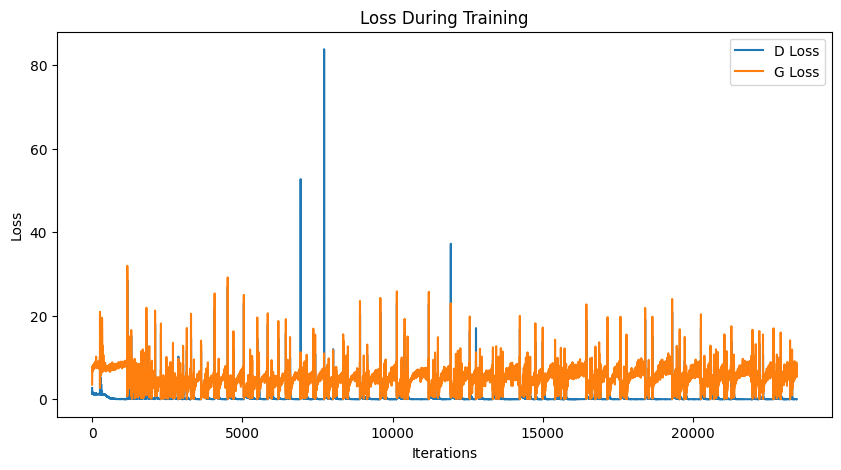

In [2]:

# Main function to train MGAN
def main():
    # Hyperparameters
    num_z = 100  # Size of z latent vector (i.e. size of generator input)
    beta = 0.5   # Diversity parameter beta
    num_gens = 10  # Number of generators
    batch_size = 128  # Batch size
    z_prior = "gaussian"  # Prior distribution of the noise ('uniform' or 'gaussian')
    learning_rate = 0.0002  # Learning rate for optimizers
    num_epochs = 50  # Number of training epochs
    image_size = 64  # Spatial size of training images
    num_channels = 1  # Number of channels in the training images. For MNIST, it's 1
    num_gen_feature_maps = 64
    num_dis_feature_maps = 64

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Create the dataset
    dataroot = './data'
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize the images to [-1, 1]
    ])

    # Load the dataset
    trainset = torchvision.datasets.MNIST(root=dataroot, train=True,
                                          download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size,
                             shuffle=True, num_workers=2)

    # Create the MGAN model
    mgan_model = MGAN(
        num_z=num_z,
        beta=beta,
        num_gens=num_gens,
        batch_size=batch_size,
        z_prior=z_prior,
        learning_rate=learning_rate,
        num_epochs=num_epochs,
        img_size=(image_size, image_size, num_channels),
        num_gen_feature_maps=num_gen_feature_maps,
        num_dis_feature_maps=num_dis_feature_maps,
        sample_dir="samples",
        device=device
    )

    # Train the model
    mgan_model.fit(trainloader)

# Execute the main function
if __name__ == '__main__':
    main()